### Write Lpy file and save it

In [1]:
from openalea.plantgl.all import *
from numpy import arange
from math import *
import numpy as np
from util import *
import matplotlib.pyplot as plt

# Integrate L-Py with xarray-simlab

https://xarray-simlab.readthedocs.io

In [2]:
from openalea.lpy.lsysparameters import LsystemParameters
strides = 10
p1 = Polyline2D([(v,0) for v in arange(0,1.01,1/strides)])
p2 = Polyline2D([(2*sin(a)/pi,2*(cos(a))/pi) for a in arange(0,pi/2+0.01,pi/(2*strides))])
p3 = Polyline2D([(-0.5,0),(0,-0.1),(0.5,0)])
rd = Polyline2D([(0,0.1),(0.7,1),(1,0.01)])

lp = LsystemParameters()
lp.add(name='strides', value=strides)
lp.add_curve(name='path1', value=p1)
lp.add_curve(name='path2', value=p2)
lp.add_curve(name='section', value=p3)
lp.add_function(name = 'radius', value=rd)
lp.set_option('Turtle Path Optimization',0)

In [3]:
%%writefile .lpydevel.lpy
from openalea.plantgl.scenegraph.colormap import *
from util import *
from random import randint

cmap = PglMaterialMap(0,25)

extern(flush_delay = None)
extern(nb_metamers = None)
extern(step_delta = None)

module Metamer(t, size, lighting, allocation)
module Apex(t)
Axiom:  _(0.3)@Gc SetColor(green) Apex(0)

production:
Apex(t) :
    if (t % flush_delay) < step_delta and (t // flush_delay) < nb_metamers:
        nproduce Metamer(MetamerParams(t=0, size=0.5)) /(180+randint(-10,10))
    produce Apex(t+step_delta)

Metamer(p):
    p.t += step_delta
    p.size += p.allocation 
    produce Metamer(p)
interpretation:
Apex(t) --> F(1) @O
Metamer(p) :
    l = p.size
    nproduce F(l/3)  [SetColor(cmap(p.lighting)) _(0.1) 
    nproduce @Gc Sweep(interpolate(path1, path2, max(1,p.t/5)), section, l,l/strides, l/2, radius)]

Overwriting .lpydevel.lpy


### Definition of the process from the lpy model

In [4]:
import xsimlab as xs
from lpy_simlab_process import xs_lpyprocess

_ = xs_lpyprocess('LpyDevel', '.lpydevel.lpy', lp, modulestoconsider=['Metamer'], 
              globaldependencies={'Metamer_lighting' : 'light', 'Metamer_allocation' : 'carbon'} )

### Definition of the light interception process

In [5]:
@xs.process
class Light():
    # process input
    Metamer = xs.foreign(LpyDevel, 'Metamer')
    lscene = xs.foreign(LpyDevel, 'lscene')
    lstring = xs.foreign(LpyDevel, 'lstring')
    
    # process output
    Metamer_lighting = xs.variable(dims='Metamer', global_name='Metamer_lighting', intent='inout')
    
    @xs.runtime()
    def run_step(self):
        from openalea.plantgl.light import directionalInterception, diffuseInterception
        #res = diffuseInterception(self.lscene)
        res = directionalInterception(self.lscene, [(0,90,1)], screenresolution=0.1)
        
        self.Metamer_lighting = np.zeros(len(self.Metamer))
        for k,v in res.items():
            if self.lstring[k].name == 'Metamer':
                self.Metamer_lighting[self.lstring[k][0].uid] = v

### Definition of the carbon allocation process

In [6]:
@xs.process
class CarbonAllocation():
    conv_rate = 0.01
    res_conv_rate = 0.5

    # process input
    Metamer_t = xs.foreign(LpyDevel, 'Metamer_t')
    Metamer_lighting = xs.foreign(Light, 'Metamer_lighting')
        
    # process output
    Metamer_allocation = xs.variable(dims='Metamer', global_name='Metamer_allocation',  intent='inout')
    Metamer_demand = xs.variable(dims='Metamer', intent='out')
    reserves = xs.variable(intent='inout')
    
    @xs.runtime(args=['step_delta'])
    def run_step(self, step_delta):
        carbon = (self.Metamer_lighting * self.conv_rate) 
        self.Metamer_demand = growth_rate(np.array(self.Metamer_t))*step_delta
        
        autoallocated = np.minimum(carbon, self.Metamer_demand)      
        demand = self.Metamer_demand - autoallocated
        supply = carbon - autoallocated
        
        total_demand = sum(demand)
        total_supply = sum(supply) + self.reserves
        
        ratio = min(1,total_supply/total_demand) if total_demand > 0 else 0
        nreserves = (total_supply - total_demand*ratio) - self.reserves
        self.reserves += nreserves if nreserves < 0 else nreserves*self.res_conv_rate
        self.Metamer_allocation = autoallocated+demand*ratio

### Create xarray-simlab model and simulation setup with the three processes

In [7]:
model = xs.Model({ 'devel': LpyDevel  , 'light' : Light  , 'carbon' : CarbonAllocation  })
model.visualize(show_inputs=False, show_variables=False)
ds = xs.create_setup(
    model=model,
    clocks={ 'time': np.linspace(0, 20, 200) },
    input_vars= LpyDevel.init_vars({ 'devel': { 'flush_delay' : 2, 'nb_metamers' : 5 },
                                     'carbon' : { 'reserves' : 10 }}),
    output_vars={ 'devel__Metamer_size': 'time',
                  'light__Metamer_lighting': 'time',
                  'carbon__Metamer_allocation': 'time',
                  'carbon__reserves': 'time' })


### Run the model and inspect results

In [8]:
from lpy_simlab_process import xs_lpydisplay_hook
ds_out = ds.xsimlab.run(model=model, hooks=xs_lpydisplay_hook('devel', scale = 1/50, delay = 0.01))

SceneWidget(scenes=[{'id': 'FkVMzS1hUiplc0PsTRGdj8gW6', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

### Plot output

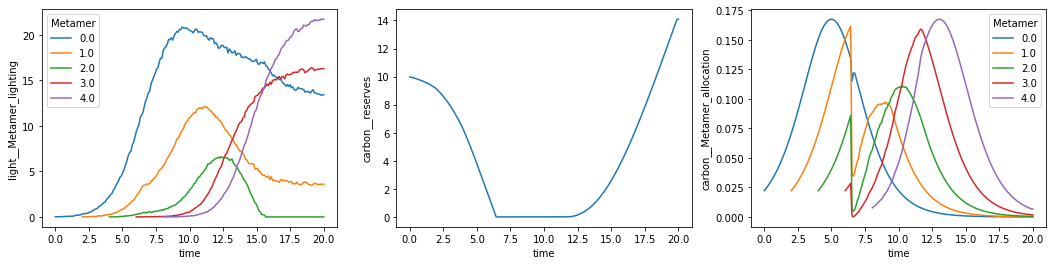

In [9]:
plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
ds_out.light__Metamer_lighting.plot.line(x='time')
plt.subplot(1, 3, 2)
ds_out.carbon__reserves.plot.line(x='time')
plt.subplot(1, 3, 3)
ds_out.carbon__Metamer_allocation.plot.line(x='time'); plt.show()